In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.integrate import odeint

%matplotlib inline

In [2]:
# Fixed Constants
rho_F = 9400.
rho_L = 1800.
gamma_F = 3.2
gamma_L = 22.
eta_F = 180.
eta_L = 230.
C = 10.4 # Forbes constant
beta_AT = 0.14 # Adaptive Thermogenesis
beta_TEF = 0.1 # Thermic Effect of Feeding
K = 0

def forbes(F):
    C1 = C * rho_L / rho_F
    return C1 / (C1 + F)

def energy_balance(F, L, EI, PAL):
    p = forbes(F)
    a1 = (1. / PAL - beta_AT) * EI - K - gamma_F * F - gamma_L * L
    a2 = (1 - p) * eta_F / rho_F + p * eta_L / rho_L + 1. / PAL
    return a1 / a2

def weight_odesystem(t, y, EI, PAL):
    F, L = y[0], y[1]
    p, EB = forbes(F), energy_balance(F, L, EI, PAL)
    return np.array([(1 - p) * EB / rho_F , p * EB / rho_L])

def fat_mass(BW, age, H, sex):
    BMI = BW / H**2.
    if sex == "male":
        return BW * (-103.91 + 37.31 * np.log(BMI) + 0.14 * age) / 100
    else:
        return BW * (-102.01 + 39.96 * np.log(BMI) + 0.14 * age) / 100

### Problem 1

In [3]:
ode_wrapper = lambda x, y : weight_odesystem(_, y, 2025, 1.5)

def rk4(f, y0, a, b, N):
    h = (b-a)/float(N)
    x = np.linspace(a,b,N+1)
    y = [y0]
    for i in xrange(int(N)):
        k1 = f(x[i], y[i])
        k2 = f(x[i] + h/2., y[i] + h/2.*k1)
        k3 = f(x[i] + h/2., y[i] + h/2.*k2)
        k4 = f(x[i+1], y[i] + h*k3)
        y.append(y[i] + h/6.*(k1 + 2*k2 + 2*k3 + k4))
    return x, y

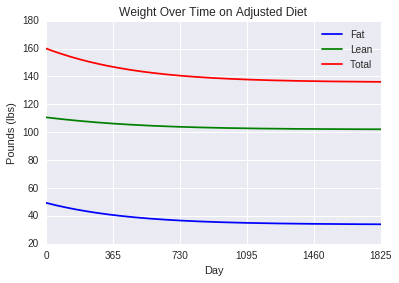

In [4]:
BW = 72.5748
age = 38
H = 1.7272
sex = "female"

F0 = fat_mass(BW, age, H, sex)
L0 = BW - F0
y0 = [F0, L0]

x, y = rk4(ode_wrapper, y0, 0, 365*5, 365*5)
y = np.array(y)
F = y[:,0]
L = y[:,1]

kg_to_lbs = 2.20462
plt.plot(x, kg_to_lbs*F, label="Fat", color="b")
plt.plot(x, kg_to_lbs*L, label="Lean", color="g")
plt.plot(x, kg_to_lbs*(F+L), label="Total", color="r")
plt.ylabel("Pounds (lbs)")
plt.xlabel("Day")
plt.xticks(np.arange(min(x), max(x)+1, 365))
plt.legend(loc="upper right")
plt.axis([0,365*5,20,180])
plt.title("Weight Over Time on Adjusted Diet")

### Problem 2

In [5]:
stage1 = lambda x,y : weight_odesystem(_, y, 1600, 1.7)
stage2 = lambda x,y : weight_odesystem(_, y, 2025, 1.5)

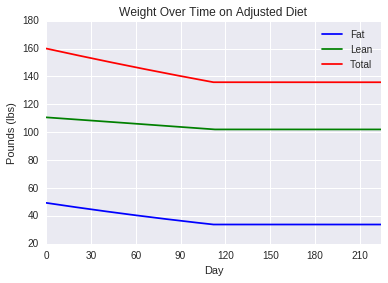

In [6]:
x1, y1 = rk4(stage1, y0, 0, 16*7, 16*7)
y1 = np.array(y1)

x2, y2 = rk4(stage2, y1[-1,:], 16*7, (32)*7, 16*7)
y2 = np.array(y2)
x = np.hstack((x1,x2))
y = np.vstack((y1, y2))
F = y[:,0]
L = y[:,1]

kg_to_lbs = 2.20462
plt.plot(x, kg_to_lbs*F, label="Fat", color="b")
plt.plot(x, kg_to_lbs*L, label="Lean", color="g")
plt.plot(x, kg_to_lbs*(F+L), label="Total", color="r")
plt.ylabel("Pounds (lbs)")
plt.xlabel("Day")
plt.xticks(np.arange(min(x), max(x)+1, 30))
plt.legend(loc="upper right")
plt.axis([0,32*7,20,180])
plt.title("Weight Over Time on Adjusted Diet")

### Problem 3

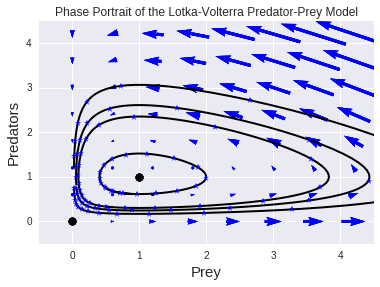

In [7]:
a, b = 0., 13. # (Nondimensional) Time interval for one period
alpha = 1. / 3 # Nondimensional parameter
dim = 2 # dimension of the system

# Note: swapping order of arguments to match the calling convention
# used in the built in IVP solver.
def Lotka_Volterra(y, x):
    return np.array([y[0] * (1. - y[1]), alpha * y[1] * (y[0] - 1.)])

y01 = np.array([.5, 1/3.])
y02 = np.array([.5,.75])
y03 = np.array([1/16., 3/4.])
y04 = np.array([1/40., .75])

for y0 in [y01, y02, y03, y04]:
    subintervals = 200
    # Using the built in ode solver
    Y = odeint(Lotka_Volterra, y0, np.linspace(a, b, subintervals))

    # Plot the direction field
    Y1, Y2 = np.meshgrid(np.arange(0, 4.5, .2), np.arange(0, 4.5, .2), 
                         sparse=True, copy=False)
    U, V = Lotka_Volterra((Y1, Y2), 0)
    Q = plt.quiver(Y1[::3, ::3], Y2[::3, ::3], U[::3, ::3], V[::3, ::3], 
                   pivot='mid', color='b', units='dots',width=3.)
    # Plot the 2 Equilibrium points
    plt.plot(1, 1, 'ok', markersize=8)
    plt.plot(0, 0, 'ok', markersize=8)
    # Plot the solution in phase space
    plt.plot(Y[:,0], Y[:,1], '-k', linewidth=2.0)
    plt.plot(Y[::10,0], Y[::10,1], '*b')

plt.axis([-.5, 4.5, -.5, 4.5])
plt.title("Phase Portrait of the Lotka-Volterra Predator-Prey Model")
plt.xlabel('Prey',fontsize=15)
plt.ylabel('Predators',fontsize=15)
plt.show()

### Problem 4

In [11]:
def predator_prey(alpha, beta, initial_cond):
    def Logistic_Model(y, x):
        dU = y[0]*(1. - y[0] - y[1])
        dV = alpha*y[1]*(y[0] - beta)
        return np.array([dU, dV])

    a, b = 0., 20. # (Nondimensional) Time interval for one period
    #alpha = 1. # Nondimensional parameter
    #beta = 1.1
    dim = 2 # dimension of the system

    #y01 = np.array([1/3., 1/3.])
    #y02 = np.array([1/2., 1/5.])


    for y0 in initial_cond:
        subintervals = 200
        # Using the built in ode solver
        Y = odeint(Logistic_Model, y0, np.linspace(a, b, subintervals))

        # Plot the direction field
        Y1, Y2 = np.meshgrid(np.arange(0, 1.5, .1), np.arange(0, 1.5, .1), 
                             sparse=True, copy=False)
        U, V = Logistic_Model((Y1, Y2), 0)
        Q = plt.quiver(Y1[::3, ::3], Y2[::3, ::3], U[::3, ::3], V[::3, ::3], 
                       pivot='mid', color='b', units='dots',width=3.)
        
        # Plot the solution in phase space
        plt.plot(Y[:,0], Y[:,1], '-k', linewidth=2.0)
        plt.plot(Y[::10,0], Y[::10,1], '*b')
        
        # Plot the 2 Equilibrium points
        plt.plot(0, 0, 'ok', markersize=8)
        plt.plot(1, 0, 'ok', markersize=8)
        plt.plot(beta, 1 - beta, 'ok', markersize=8)

    plt.axis([-.25, 1.75, -.25, 1.75])
    plt.title("Phase Portrait of the Logistic Predator-Prey Model")
    plt.xlabel('Prey',fontsize=15)
    plt.ylabel('Predators',fontsize=15)
    plt.show()
    

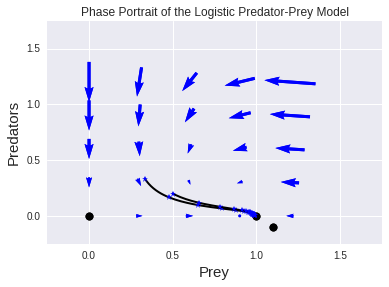

In [12]:
predator_prey(1, 1.1, [np.array([1/3., 1/3.]), np.array([1/2., 1/5.])])

In [13]:
predator_prey(1,.3, [np.array([1/3., 1/3.]), np.array([1/2., 1/5.])])